In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pycqed.analysis_v2.base_analysis import BaseDataAnalysis
from pycqed.analysis import measurement_analysis as ma
from pycqed.analysis import analysis_toolbox as a_tools
from pycqed.analysis_v2 import readout_analysis as ra
import os
import matplotlib
import matplotlib.colors as mc
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.mixture import GaussianMixture as GM
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from importlib import reload
matplotlib.rcParams.update({'font.size': 20})
a_tools.datadir = "Q:\\USERS\\nathan\\data"

c:\users\nathan\masterthesis\code\controlsoftware\pycqed_py3\data
Data directory set to: c:\users\nathan\masterthesis\code\controlsoftware\pycqed_py3\data


Welcome to pygsti version 0.9.7!
There have been some major changes between this version and 0.9.6 - ones that break backward compatibility.  If you're trying to run an old script and nothing works, DON'T PANIC; we've tried to make the transition easy.  More often then not, you can just run `pyGSTi/scripts/upgrade2v0.9.7.py` on your old script or notebook files and you'll be up and running again.  For more information, see the pyGSTi FAQ.ipynb.

If this warning annoys you run:
  `export PYGSTI_BACKCOMPAT_WARNING=0` from the command line or
  `import os; os.environ['PYGSTI_BACKCOMPAT_WARNING'] = '0'` in a script or
     notebook *before* importing pygsti and the the madness will stop.


In [2]:
from pycqed.utilities import math
levels = ['g', 'e', 'f']

# SSRO timestamps

# Timetraces
# t_start = ['20191112_141158', '20191112_141353', '20191112_141550'] 
t_start = ['20191112_150236', '20191112_150432', '20191112_150627'] 

ref_state = 'g'
kw = dict(non_ortho_basis=True, basis_2nd=False)
m_a = {l: ma.MeasurementAnalysis(timestamp=t_start[i]) for i,l in enumerate(levels)}
iq_traces = {l: m_a[l].measured_values[0]
                + 1j * m_a[l].measured_values[1] for l in levels}
final_basis_labels = ['ge'] # default basis vector if only qubit ro

basis = [iq_traces[l] - iq_traces[ref_state] for l in levels
         if l != ref_state]
basis_labels = [l + ref_state for l in levels if l != ref_state]
final_basis = math.gram_schmidt(np.array(basis).transpose())
final_basis = final_basis.transpose()  # obtain basis vect as rows
# basis using second vector as primary vector
basis_2nd = list(reversed(basis))
final_basis_2nd = math.gram_schmidt(np.array(basis_2nd).transpose())
final_basis_2nd = final_basis_2nd.transpose()
if kw.get('non_ortho_basis', False):
    final_basis_labels = basis_labels
    final_basis = np.array([final_basis[0], final_basis_2nd[0]])
elif kw.get('basis_2nd', False):
    final_basis_labels = [basis_labels[1]] + ['$\\perp$']
    final_basis = final_basis_2nd
else:
    final_basis_labels = [basis_labels[0]] + ['$\\perp$']

final_basis_labels

c:\users\nathan\masterthesis\code\env\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning:

dataset.value has been deprecated. Use dataset[()] instead.

c:\users\nathan\masterthesis\code\env\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning:


Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.



Q:\USERS\nathan\data\20191112\150236_timetrace_g_qb1\timetrace_g_qb1_measured_values_vs_None.png ::loc
Q:\USERS\nathan\data\20191112\150432_timetrace_e_qb1\timetrace_e_qb1_measured_values_vs_None.png ::loc
Q:\USERS\nathan\data\20191112\150627_timetrace_f_qb1\timetrace_f_qb1_measured_values_vs_None.png ::loc


['eg', 'fg']

In [5]:
cmap = plt.get_cmap("tab20")
states = 'gef'
colors = {s: [cmap(j*2 + i) for i in range(2)] for j,s in enumerate(states)}
colors_diffs = [plt.get_cmap("tab20b")(13), plt.get_cmap("tab20b")(14),
               plt.get_cmap("tab20c")(12), plt.get_cmap("tab20c")(13)]

c:\users\nathan\masterthesis\code\env\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning:

Casting complex values to real discards the imaginary part



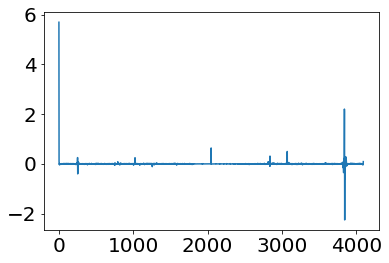

In [13]:
fft = np.fft.fft(np.r(iq_traces['e']))
freqs = np.fft.fftfreq(len(fft), 1/1.8e9)
plt.plot(freqs, np.abs(fft))

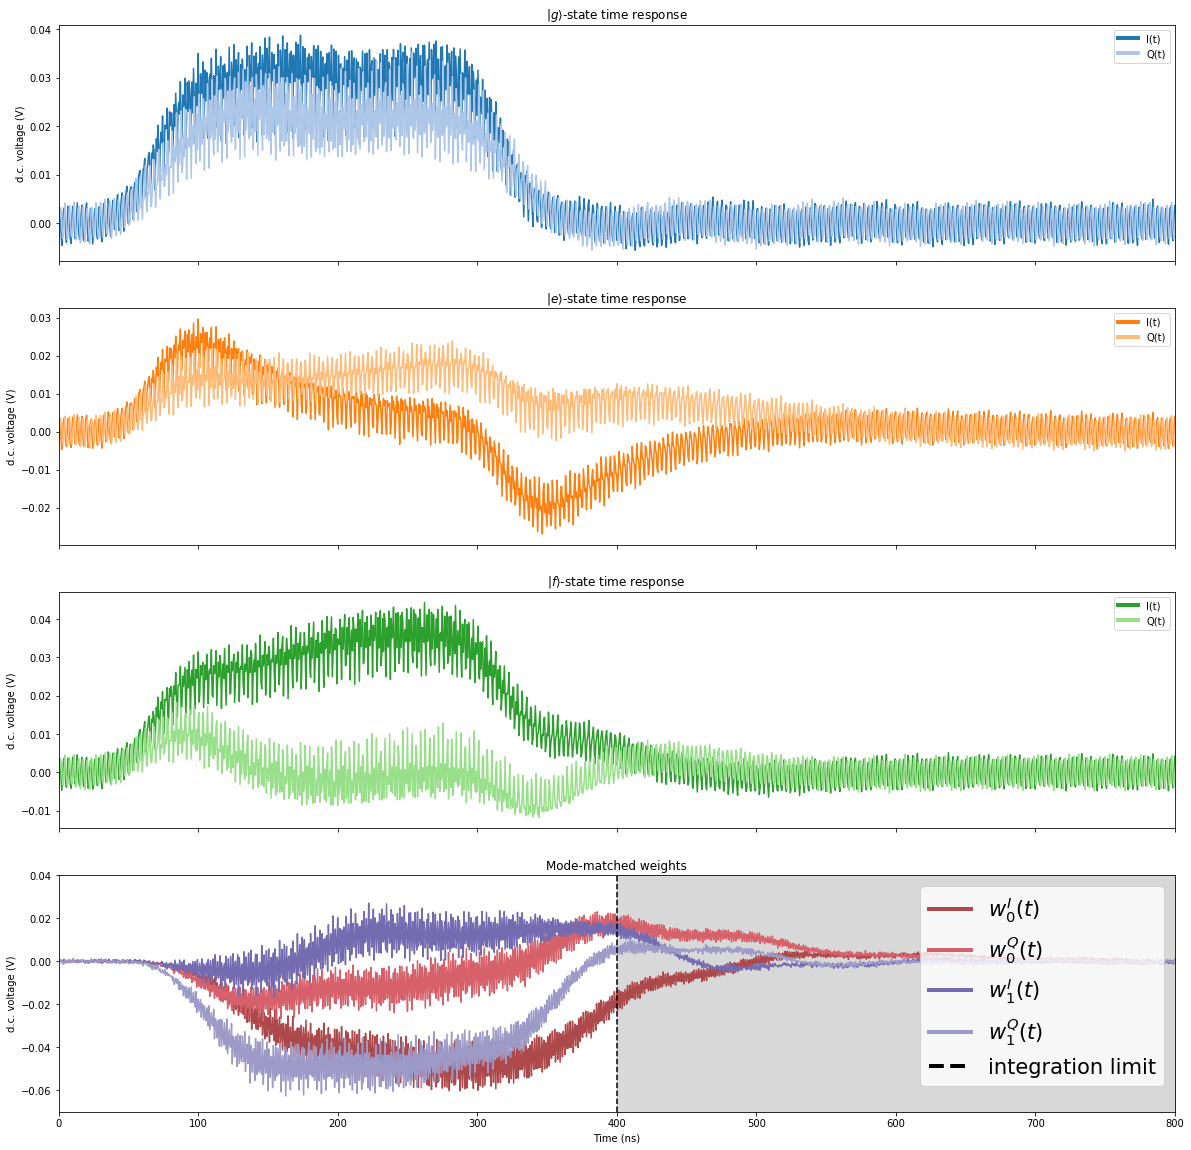

In [6]:
npoints = len(m_a['g'].sweep_points)
mod_freq = 313899000.0
qbname = 'qb1'
plot_ylabels = dict(g='d.c. voltage (V)',
                    e='d.c. voltage (V)',
                    f='d.c. voltage (V)')
tbase = np.linspace(0, npoints/1.8e9, npoints, endpoint=False)
modulation = np.exp(2j * np.pi * mod_freq * tbase)
fig, ax = plt.subplots(len(levels) + 1, figsize=(20,20), sharex=True)
#fig.set_title('Mode-matched weights ' + qbname )
#             "".join('\n' + m_a[l].timestamp_string for l in levels) + f'\nWeight Basis: {final_basis_labels}'
                
for i, l in enumerate(levels):
    ax[i].set_title(f"$|{l}\\rangle$-state time response")
    ax[i].plot(tbase / 1e-9, np.real(iq_traces[l] * modulation), '-',color=colors[l][0],
             label='I(t)')
    ax[i].plot(tbase / 1e-9, np.imag(iq_traces[l] * modulation), '-',color=colors[l][1],
             label='Q(t)')
    ax[i].set_ylabel(plot_ylabels[l])
    ax[i].set_xlim(0, kw.get('tmax', 800))
    leg = ax[i].legend(loc='upper right')
    for legobj in leg.legendHandles:
        legobj.set_linewidth(4.0)
    

for i, vect in enumerate(final_basis):
    ax[-1].plot(tbase / 1e-9, np.real(vect * modulation), '-', color=colors_diffs[i*2+0],
                label=r'$w_{{{}}}^{{I}}(t)$'.format(i))
    ax[-1].plot(tbase / 1e-9, np.imag(vect * modulation), '-',color=colors_diffs[i*2+1],
                label=r'$w_{{{}}}^{{Q}}(t)$'.format(i))
    ax[-1].legend(loc='upper right')
ax[-1].set_xlabel("Time (ns)")
ax[-1].set_ylabel('d.c. voltage (V)')
ax[-1].set_title(f"Mode-matched weights")
ax[-1].axvline(400, color='k', linestyle='--', label= 'integration limit')
ax[-1].fill_betweenx([-0.075,0.04], [400], [800], color='grey',alpha=0.3)
ax[-1].set_ylim([-0.07,0.04])
leg = ax[-1].legend(loc='upper right', prop={"size":21})
for legobj in leg.legendHandles:
    legobj.set_linewidth(4.0)

In [8]:
%matplotlib notebook

<IPython.core.display.Javascript object>


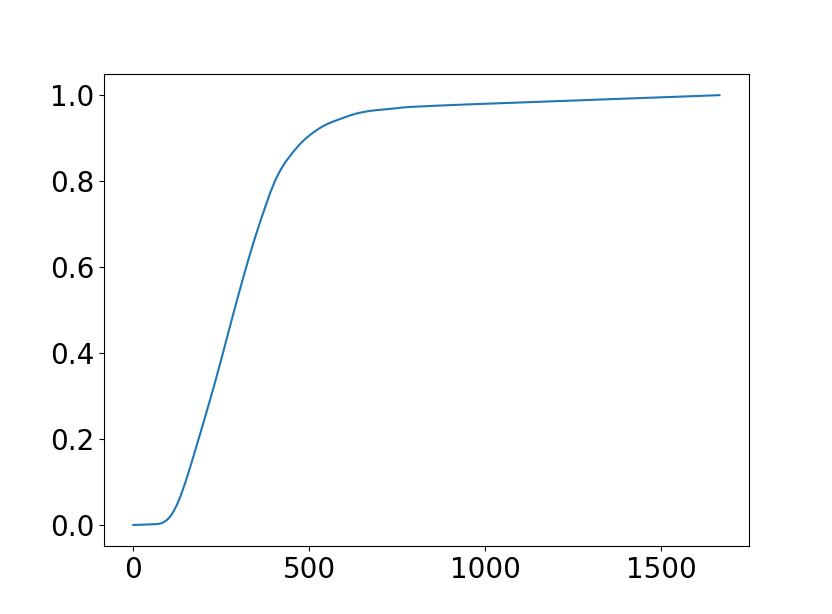

In [20]:
crop = 3000
plt.plot(tbase[:crop] / 1e-9, np.cumsum(np.abs(np.real(final_basis[0][:crop] * modulation[:crop])) +
                                np.abs(np.imag(final_basis[0][:crop] * modulation[:crop])))/
                                 (np.sum(np.abs(np.real(final_basis[0][:crop] * modulation[:crop]))) +
                                       np.sum(np.abs(np.imag(final_basis[0][:crop] * modulation[:crop])))), '-', 
                label=r'$w_{{{}}}^{{I}}(t)$'.format(i))
# plt.xlim([0,400])

In [18]:
tbase[:crop].shape

(2024,)